In [1]:
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy

In [2]:
#Read de data from original file
data0 = pd.read_csv("recipeData.csv",encoding='latin-1',index_col=0)

## Understanding the data

In [3]:
data0.head()

,Name,URL,Style,StyleID,Size(L),OG,FG,ABV,IBU,Color,...,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PitchRate,PrimaryTemp,PrimingMethod,PrimingAmount,UserId
BeerID,,,,,,,,,,,,,,,,,,,,,
1,Vanilla Cream Ale,/homebrew/recipe/view/1633/vanilla-cream-ale,Cream Ale,45,21.77,1.055,1.013,5.48,17.65,4.83,...,1.038,70.0,NaN,Specific Gravity,All Grain,NaN,17.78,corn sugar,4.5 oz,116.0
2,Southern Tier Pumking clone,/homebrew/recipe/view/16367/southern-tier-pumk...,Holiday/Winter Special Spiced Beer,85,20.82,1.083,1.021,8.16,60.65,15.64,...,1.070,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,955.0
3,Zombie Dust Clone - EXTRACT,/homebrew/recipe/view/5920/zombie-dust-clone-e...,American IPA,7,18.93,1.063,1.018,5.91,59.25,8.98,...,NaN,70.0,NaN,Specific Gravity,extract,NaN,NaN,NaN,NaN,NaN
4,Zombie Dust Clone - ALL GRAIN,/homebrew/recipe/view/5916/zombie-dust-clone-a...,American IPA,7,22.71,1.061,1.017,5.80,54.48,8.50,...,NaN,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,NaN
5,Bakke Brygg Belgisk Blonde 50 l,/homebrew/recipe/view/89534/bakke-brygg-belgis...,Belgian Blond Ale,20,50.00,1.060,1.010,6.48,17.84,4.57,...,1.050,72.0,NaN,Specific Gravity,All Grain,NaN,19.00,Sukkerlake,6-7 g sukker/l,18325.0


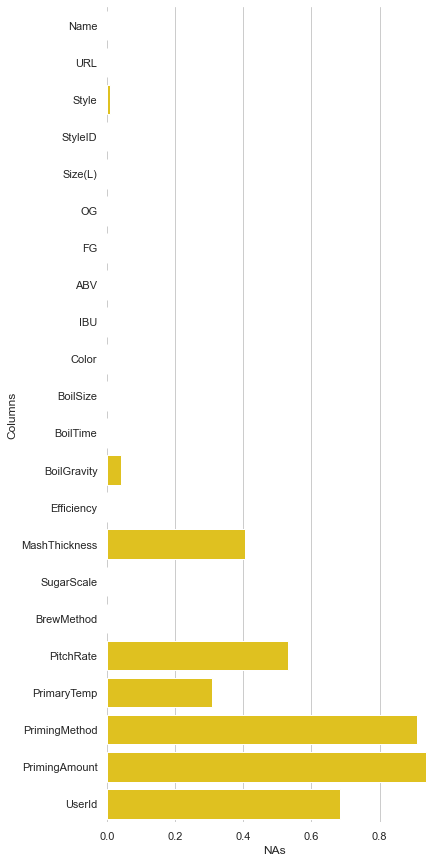

In [4]:
#Visualizing what percentage of data is missing at each column

n = len(data0['Name'])
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(x=data0.isna().sum()/n, y=data0.columns,color="gold")
ax.set(ylabel="Columns",
       xlabel="NAs")
sns.despine(left=True, bottom=True)

In [5]:
data0['SugarScale'].value_counts() #Exploring balance of this variable. (Highly unbalanced)

Specific Gravity    71959
Plato                1902
Name: SugarScale, dtype: int64

In [6]:
data0['BrewMethod'].value_counts() #Exploring balance of this variable

All Grain       49692
BIAB            12016
extract          8626
Partial Mash     3527
Name: BrewMethod, dtype: int64

In [7]:
data0['Style'].value_counts() #Exploring balance of our target variable (Highly unbalanced)

American IPA              11940
American Pale Ale          7581
Saison                     2617
American Light Lager       2277
American Amber Ale         2038
                          ...  
Apple Wine                    6
Lichtenhainer                 6
Pyment (Grape Melomel)        5
Traditional Perry             2
French Cider                  2
Name: Style, Length: 175, dtype: int64

## Modifying data for ML experiments later on

In [8]:
#Keep beerstyles that account for at least 0.5% and 10% of all data respectively, 
#for we want to be able to perform stratified cross-validation later on.
#We will conduct two experiments, the second with much fewer classes for classification than the first.
#(The data set for the second experiment is obtained by uncommenting the second mask)

y = data0['Style'].value_counts() > 0.005*len(data0['Style']) 
#y = data0['Style'].value_counts() > 0.1*len(data0['Style']) 

In [9]:
data1 = data0[data0['Style'].isin(set(y[y].index))]

In [10]:
data2=data1[data1['SugarScale']=='Specific Gravity'] #We will keep the majority of the SugarScale classes only

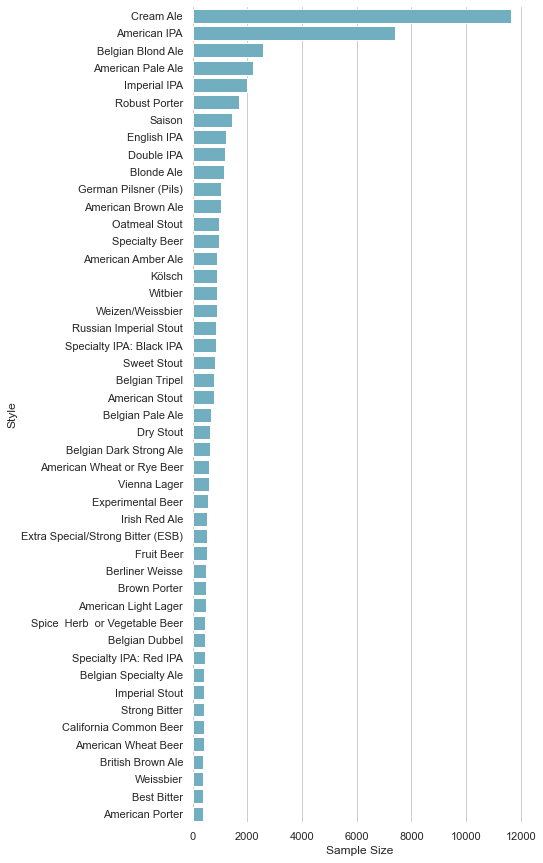

In [11]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(x=data2['Style'].value_counts(), y=data2['Style'].value_counts().index,color="c")
ax.set(ylabel="Style",
       xlabel="Sample Size")
sns.despine(left=True, bottom=True)
plt.savefig('img/samples.png',bbox_inches = 'tight',dpi=700)
#plt.savefig('img/samples2.png',bbox_inches = 'tight',dpi=700) #for the second data set

<AxesSubplot:>

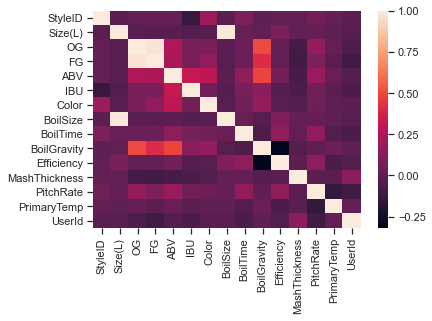

In [12]:
#Visualizing correlations between variables
sns.set(style='ticks')
sns.heatmap(data2.corr())

In [13]:
#We will drop those with too much info missing or that are not too informative.
#MashThickness, PitchRate, PrimaryTemp, PrimingMethod, and PrimingAmount, are droped due to the % of NA's.
#UserId, URL, and Name are dropped because they are not usefull.
#Size&BoilSize provide irrelevant info (beer-type is unrelated to the amount made) and are heavily correlated.
#OG & FG are highly correlated
#SugarScale is droped since we already kept the majority class in this column
to_drop = ['Name','URL','StyleID','MashThickness','PitchRate','PrimaryTemp','PrimingMethod','PrimingAmount',\
           'Size(L)','BoilSize','UserId', 'FG', 'SugarScale']

In [14]:
data3=data2.drop(to_drop,axis=1).dropna()

In [15]:
data3 #After cleaning we kept almost 73% of the data for the multiclass dataset

,Style,OG,ABV,IBU,Color,BoilTime,BoilGravity,Efficiency,BrewMethod
BeerID,,,,,,,,,
1,Cream Ale,1.055,5.48,17.65,4.83,75,1.038,70.0,All Grain
5,Belgian Blond Ale,1.060,6.48,17.84,4.57,90,1.050,72.0,All Grain
6,American Pale Ale,1.055,5.58,40.12,8.00,70,1.047,79.0,All Grain
8,Cream Ale,1.054,5.36,19.97,5.94,75,1.040,70.0,All Grain
9,Robust Porter,1.060,5.77,31.63,34.76,75,1.042,73.0,All Grain
...,...,...,...,...,...,...,...,...,...
73854,American IPA,1.073,7.15,0.00,6.01,60,1.060,70.0,BIAB
73855,American Pale Ale,1.064,6.26,0.00,9.60,60,1.042,75.0,BIAB
73856,American IPA,1.065,6.71,49.35,4.73,30,1.098,55.0,Partial Mash


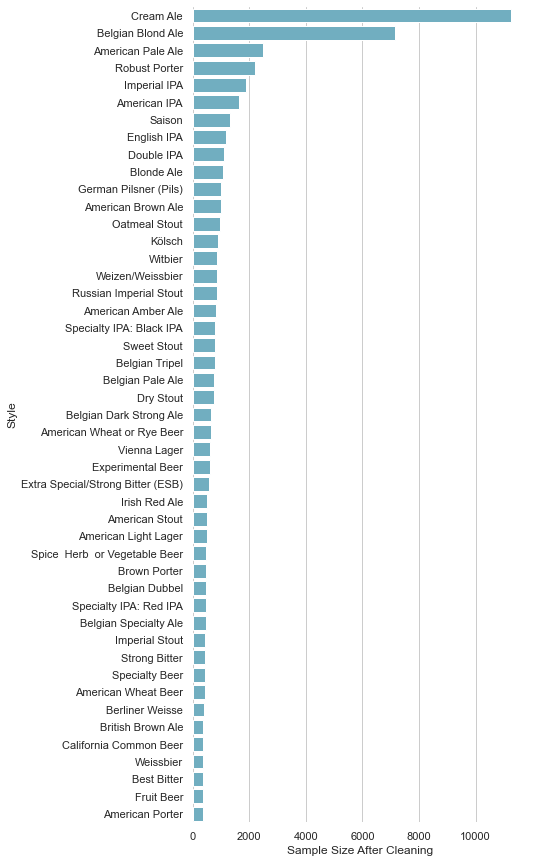

In [16]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(x=data3['Style'].value_counts(), y=data3['Style'].unique(),color="c")
ax.set(ylabel="Style",
       xlabel="Sample Size After Cleaning")
sns.despine(left=True, bottom=True)
plt.savefig('samples_after.png',bbox_inches = 'tight',dpi=700)
#plt.savefig('img/samples_after2.png',bbox_inches = 'tight',dpi=700) #for the second dataset

In [17]:
data3.to_csv('data.csv') #This is the data that we will keep for the first experiment
#data3.to_csv('data2.csv') #This is the data that we will keep for the second experiment

In [ ]:
#This particular plot should only be used especifically for the binary class dataset given that the multiple
#class dataset would take too long and poinless. The aim of this plot is to see that even with binary classes, 
#there are no clear separations in any 2D projections, let alone the multiclass dataset.
sns.set(style="white")
sns.pairplot(data3,hue='Style')
plt.savefig('img/pairs2.png',bbox_inches = 'tight',dpi=700)
#From now on we will only work with the multiple class dataset

## We will build a data set for hierarchical clustering on beer styles (classes) as the objects in euclidean space.

In [18]:
datac = data3.groupby('Style').mean() #We will deal with beer style as an observation

In [19]:
datac.head()

,OG,ABV,IBU,Color,BoilTime,BoilGravity,Efficiency
Style,,,,,,,
American Amber Ale,1.056246,5.675917,40.351038,14.209763,62.852476,1.052094,64.391043
American Brown Ale,1.058604,5.831575,36.811028,23.662547,63.136792,1.050894,65.906792
American IPA,1.063243,6.445351,72.239069,8.340987,63.522052,1.055668,65.577982
American Light Lager,1.055701,5.648909,30.979402,10.235091,60.865942,1.052374,63.887079
American Pale Ale,1.053440,5.461834,44.223330,7.189037,62.272702,1.048219,66.329078


In [20]:
#This renaming is necesary, otherwise we would have problems defining the lablel-coloring function in the 
#dendrogram later on.
datac = datac.rename(index={'Extra Special/Strong Bitter (ESB)': 'Extra Special/Strong Bitter'})
datac = datac.rename(index={'German Pilsner (Pils)': 'German Pilsner'})

In [21]:
#Distance matrix for the dendrogram
distance_matrix = linkage(datac, method='single', metric='euclidean', optimal_ordering=False)

In [22]:
#Color is a continuous variable. We will make bins for coloring in visualization.
datac['bins']=pd.Categorical(pd.cut(datac['Color'],4,labels=[1,2,3,4]))

In [23]:
#This are the colors defined for the labels. 
dgold = (206/255,173/255,0/255)
dgoldenrod = (196/255,148/255,28/255)
darkerdgoldenrod = (147/255,107/255,8/255) 
saddlebrown = (139/255,69/255,19/255)
#[dgold,goldenrod,darkgoldenrod,saddlebrown] = ['#CEAD00','#C4941C','#936B08','#8B4513']

In [24]:
#Palette defined by above colors, according to how dark a beer style is on average
palette = {}
for ind in datac.index:
    if datac.loc[ind]['bins'].astype(int) == 1:
        palette[ind] = dgold
    if datac.loc[ind]['bins'].astype(int) == 2:
        palette[ind] = dgoldenrod
    if datac.loc[ind]['bins'].astype(int) == 3:
        palette[ind] = darkerdgoldenrod
    if datac.loc[ind]['bins'].astype(int) == 4:
        palette[ind] = saddlebrown

In [25]:
#This is an alternative way to define coloring for links in the dendrogram. 
#To apply it, uncomment these lines along with the commented: hierarchy.set_link_color_... line in the 
#dendrogram configuration steps, and finally modify color threshold and above_threshold_color
#parameters of the dendrogram. In this case, a palette called "Greys" is selected, but there are other options.

#colors =  matplotlib.cm.Greys( (np.arange(100)).astype(int) )
#cmap = matplotlib.cm.rainbow(colors[:,0])
#hierarchy.set_link_color_palette([matplotlib.colors.rgb2hex(rgb[:3]) for rgb in cmap])

In [26]:
#Matplotlib config for visualization
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 30}

matplotlib.rc('font', **font)
matplotlib.style.use('seaborn-whitegrid')

### Visualizing the dendrogram to identify similar beer styles

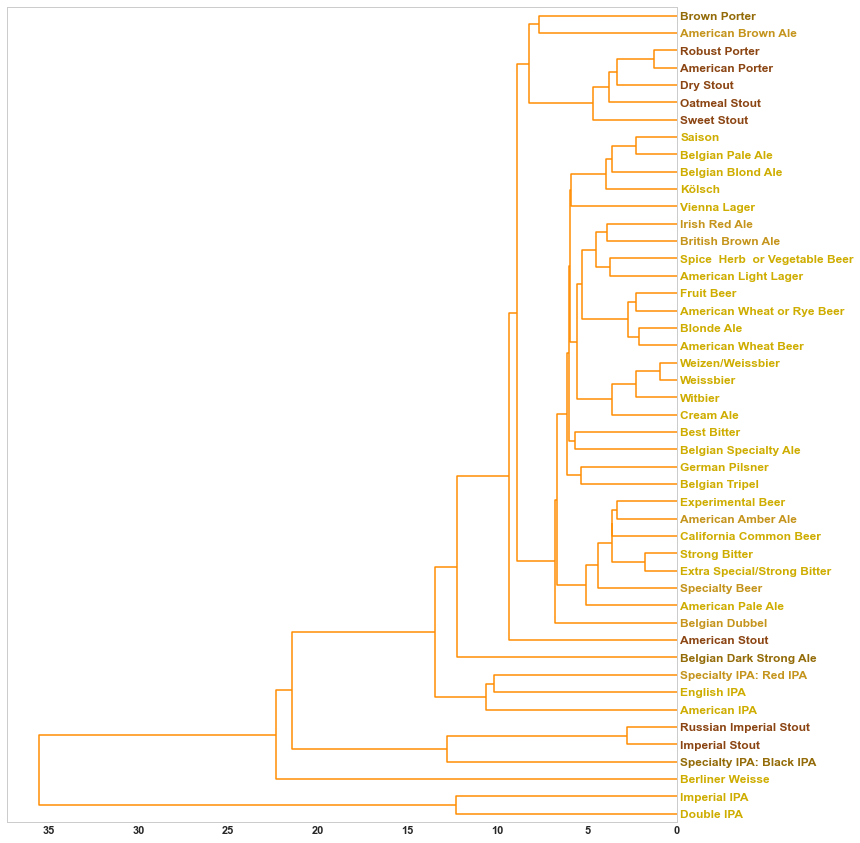

In [27]:
#Dendrogram configuration steps
plt.figure(figsize = (12,15))
#hierarchy.set_link_color_palette([matplotlib.colors.rgb2hex(rgb[:3]) for rgb in cmap])
dn = dendrogram(distance_matrix, orientation = 'left',labels = datac.index, \
                leaf_font_size=12, color_threshold = 0.01, above_threshold_color = 'darkorange')
plt.grid(b=None)

#For each label, we will get the color associated to it from our palette
ax = plt.gca()
xlbls = ax.get_ymajorticklabels()

for lbl in xlbls:
    label = str(lbl).replace(')','').split(' ')[2:]
    col = ', '.join(label).replace(',', '')
    ind = ''.join(re.findall(r"[^\"]", col)[1:-1])
    lbl.set_color(palette[ind])




plt.savefig('img/dendro.png', bbox_inches = 'tight',dpi=700)
plt.show()

In [28]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

### This two visualizations are for understanding the similarity between distributions of color and alcohol content in beer styles

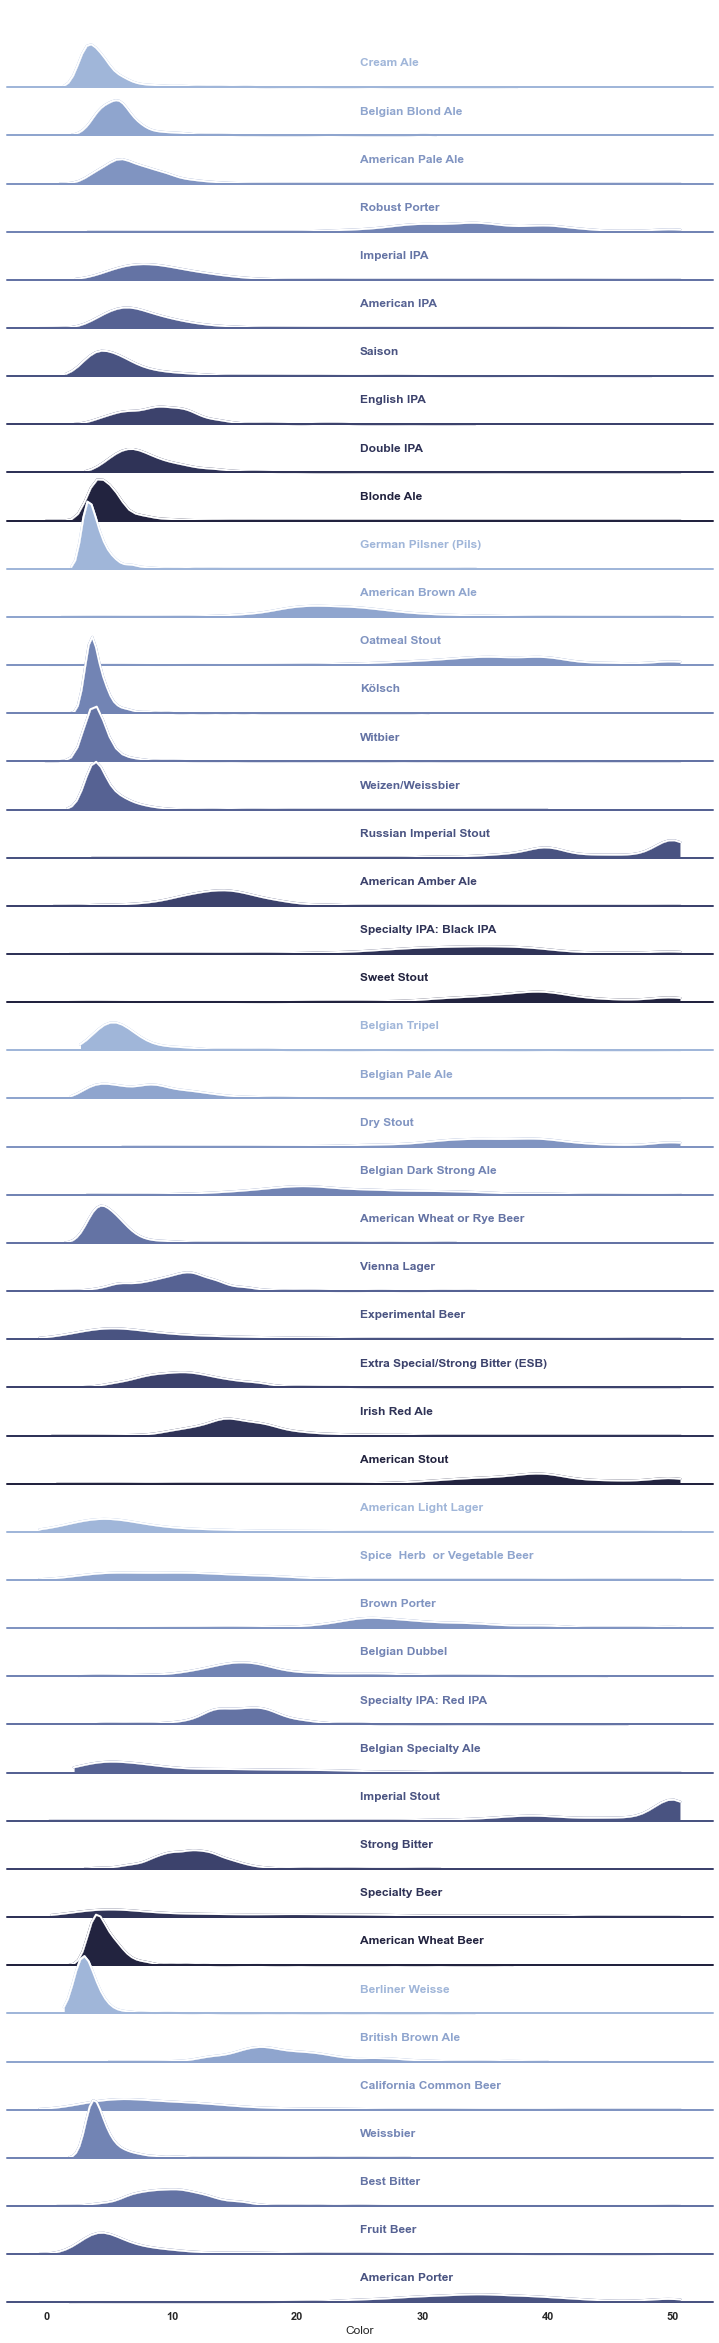

In [29]:
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.1, light=.7)
g = sns.FacetGrid(data3, row="Style", hue="Style", aspect=15, height=.7, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Color", clip_on=False, shade=True, alpha=1, lw=2, bw=.2)
g.map(sns.kdeplot, "Color", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0.5, .3, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "Color")


# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.4)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
g.savefig('img/colordist.png',dpi=700)

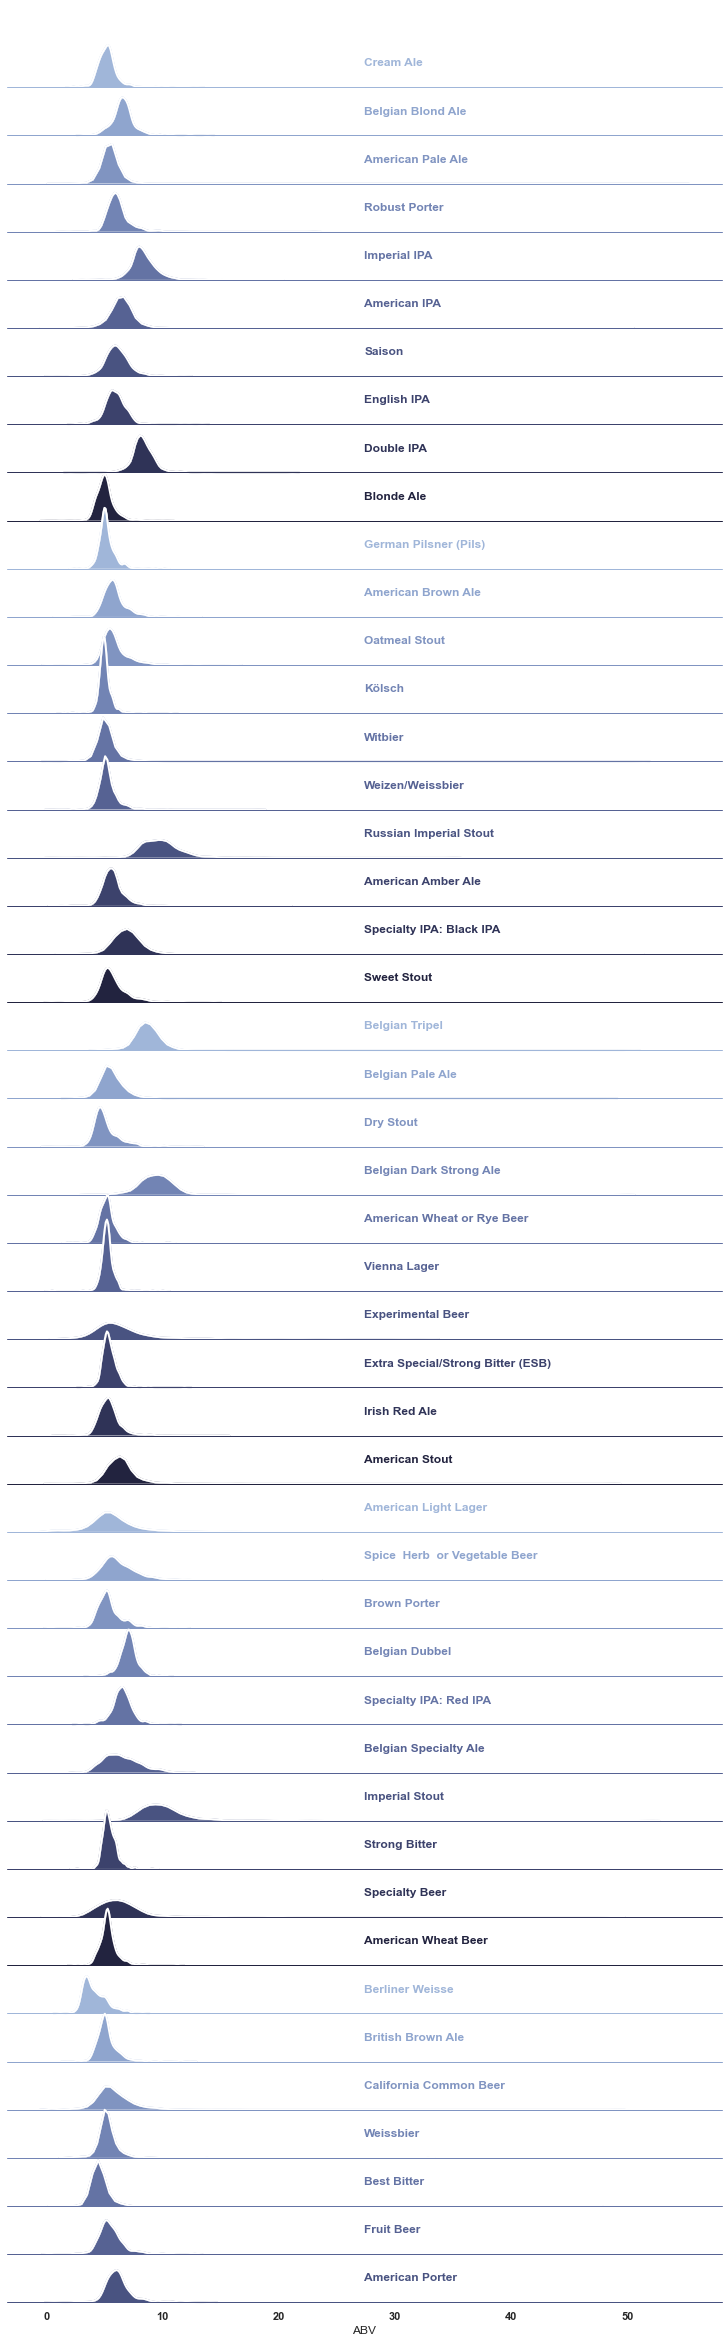

In [30]:
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.1, light=.7)
g = sns.FacetGrid(data3, row="Style", hue="Style", aspect=15, height=.7, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "ABV", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "ABV", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=1, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0.5, .3, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "ABV")


# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-0.4)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
g.savefig('img/abvdist.png', dpi=700)